In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from LDA import LDA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import colormaps, cm

import warnings
warnings.filterwarnings('ignore')

### Load data

In [2]:
data_train = np.load('data/fashion_train.npy', mmap_mode='r')
data_test = np.load('data/fashion_test.npy', mmap_mode='r')

In [3]:
X_train = data_train[:, :-1]
y_train = data_train[:, -1]

X_test = data_test[:, :-1]
y_test = data_test[:, -1]

In [4]:
clf = LDA(n_components=2)
clf.fit(X_train, y_train)

X_train_transformed = clf.transform(X_train)
X_test_transformed = clf.transform(X_test)

### Gaussian KDE

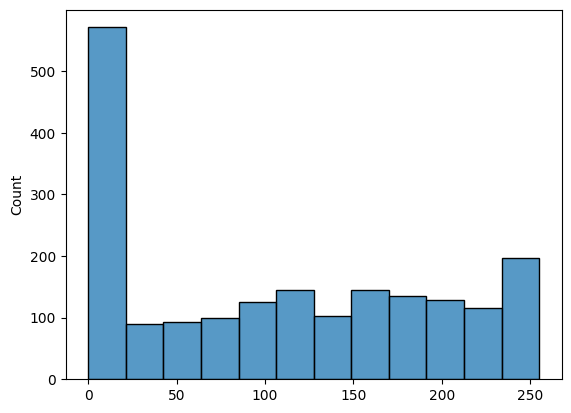

In [5]:
fig, ax = plt.subplots();

x=X_train[y_train==1][:,345]

sns.histplot(x);

In [6]:
kernel=stats.gaussian_kde(x.T)

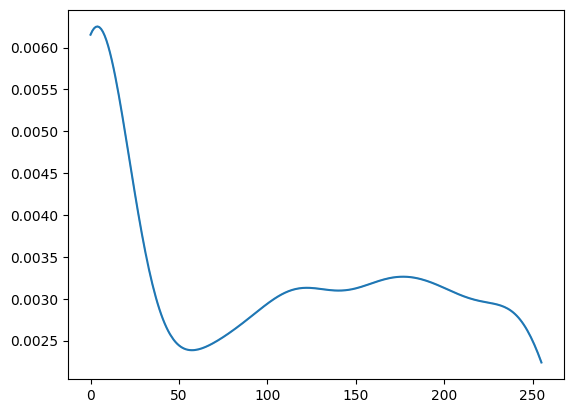

In [7]:
x1 = kernel.pdf(x)
sns.lineplot(x=x, y=x1);

### Build classifier

In [8]:
class NaiveBayes():
    def __init__(self, h, pdf_estimator):
        # User defined parameters
        self.h = h # Step size in histogram
        self.pdf_estimator = pdf_estimator # Type of pdf-estimator: hist or kde


        self.class_labels = None
        self.priors = None # Prior class probabilities
        self.conditionals = None # Class conditionals

    def get_params(self, deep=True):
        params = {'h': self.h, 'pdf_estimator': self.pdf_estimator}

        return params

    def pdf_hist(self, X, y, class_labels):
        conditionals = dict()

        for cl in class_labels:
            c = []
            for x in X[y == cl].T:
                bins = int(np.ceil((max(x)-min(x)) / self.h))
                d, upper_bound = np.histogram(x, bins=bins, density=True)

                c.append([[d, upper_bound] for d, upper_bound in zip(d, upper_bound)])

            conditionals[cl] = c

        return conditionals

    def pdf_kde(self, X, y, class_labels):
        '''
        Finds and saves kernel for each feature in each class.
        '''

        # Create dict to save kernels for each class
        kernels = dict()

        for cl in class_labels:
            # Create list to save kernels for each feature in each class
            kernels_cl = []

            for i in range(X.shape[1]):
                x = X[y == cl][:,i]
                
                kernels_cl.append(stats.gaussian_kde(x, self.h))
            
            kernels[cl] = kernels_cl

        # Save kernels
        self.kernels = kernels

    def fit(self, X, y):
        self.class_labels = np.unique(y)
        n = X.shape[0]

        # Prior class probabilities
        self.priors = {cl: sum(y==cl)/n for cl in self.class_labels}

        # Conditional probabilities
        if self.pdf_estimator == 'hist':
            self.conditionals = self.pdf_hist(X, y, self.class_labels)
        elif self.pdf_estimator == 'kde':
            self.kernel = self.pdf_kde(X, y, self.class_labels)
        else:
            'Type of pdf estimator is not available.'

    def pdf(self, cl, i, f):
        
        if self.pdf_estimator == 'kde':
            return self.kernels[cl][i].pdf(f)
        elif self.pdf_estimator == 'hist':
            for d, upper_bound in self.conditionals[cl][i]:
                if f < upper_bound:
                    return d
            return d

    def class_c_pdf(self, x, cl):
        class_conditionals = []
                    
        for i, f in enumerate(x):
            class_conditionals.append(self.pdf(cl, i, f))

        return class_conditionals

    def predict_proba(self, X):

        n, K = X.shape[0], len(self.priors)

        # For each sample compute the posterior probabilities for all classes           
        posteriors = np.empty((n, K))
        
        for i in range(n):
            
            # Likelihoods
            likelihoods = []
            for cl in self.class_labels:
                prior = self.priors[cl]

                class_conditionals = self.class_c_pdf(X[i], cl)
                likelihood = prior * np.prod(class_conditionals)
            
                likelihoods.append(likelihood)
                            
            # Normalize likelihoods to get posteriors
            posteriors[i] = likelihoods/np.sum(likelihoods)

        return posteriors

    def predict(self, X):

        posteriors = self.predict_proba(X)
        return np.argmax(posteriors, axis=1)

In [9]:
NB = NaiveBayes(0.2,'kde')
NB.fit(X_train_transformed, y_train)

In [10]:
yhat = NB.predict(X_test_transformed)

### Cross validation

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, make_scorer


In [12]:
def cross_validate(clfs, X, y):
    accuracy_scores, recall_scores, precision_scores, roc_auc_scores  = [], [], [], []

    for clf in clfs.values():
        accuracy, recall, precision, roc_auc = 0, 0, 0, 0

        num_folds = 10
        skf = StratifiedKFold(num_folds, random_state=0, shuffle=True)

        for (train_idx, val_idx) in skf.split(X,y):
            clf.fit(X[train_idx], y_train[train_idx])
            y_hat = clf.predict(X[val_idx])
            y_hat_proba = clf.predict_proba(X[val_idx])
            y_true = y[val_idx]

            accuracy += accuracy_score(y_true, y_hat)
            recall += recall_score(y_true, y_hat, average = 'macro')
            precision += precision_score(y_true, y_hat, average = 'macro')
            roc_auc += roc_auc_score(y_true, y_hat_proba, average = 'macro', multi_class = 'ovr')

        # Average scores
        accuracy /= num_folds
        recall /= num_folds
        precision /= num_folds
        roc_auc /= num_folds

        accuracy_scores.append(accuracy)
        recall_scores.append(recall)
        precision_scores.append(precision)
        roc_auc_scores.append(roc_auc)

    test_scores = pd.DataFrame({'clf_name': clfs.keys(), 'Accuracy': accuracy_scores, 'Recall': recall_scores, 'Precision': precision_scores, 'Roc_auc': roc_auc_scores})
    return test_scores

In [13]:
H = np.arange(start=0.1, stop=1.1, step=0.1)

classifiers_hist = {f'NB_{i}': NaiveBayes(h,'hist') for i, h in enumerate(H)}
classifiers_kde = {f'NB_{i}': NaiveBayes(h,'kde') for i, h in enumerate(H)}

In [14]:
scores_hist = cross_validate(classifiers_hist, X_train_transformed, y_train)
scores_kde = cross_validate(classifiers_kde, X_train_transformed, y_train)

<Axes: >

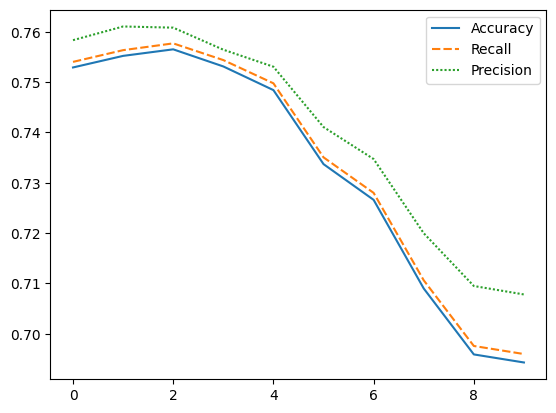

In [15]:
sns.lineplot(scores_hist[['Accuracy', 'Recall', 'Precision']])

<Axes: ylabel='Roc_auc'>

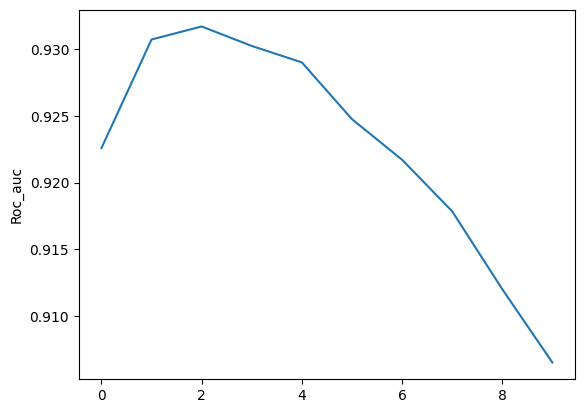

In [16]:
sns.lineplot(scores_hist['Roc_auc'])

<Axes: >

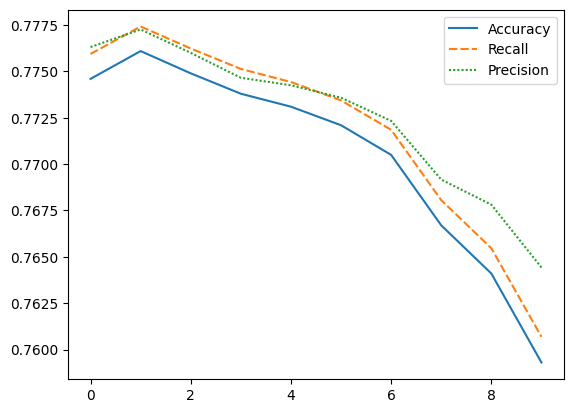

In [17]:
sns.lineplot(scores_kde[['Accuracy', 'Recall', 'Precision']])

<Axes: ylabel='Roc_auc'>

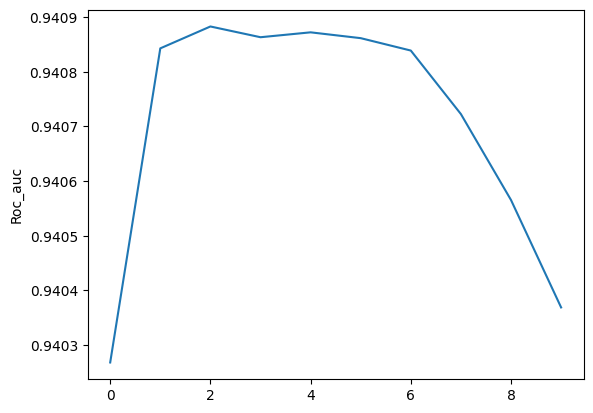

In [18]:
sns.lineplot(scores_kde['Roc_auc'])

### Test

### Visualization

In [19]:
d = {'LDA1':X_train_transformed[:,0], 'LDA2':X_train_transformed[:,1]}
X = pd.DataFrame(d)
y=y_train

In [20]:
# Step size in grid
h = 0.2

# Create a grid
x_min, x_max = X['LDA1'].min() - 1, X['LDA1'].max() + 1
y_min, y_max = X['LDA2'].min() - 1, X['LDA2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Define classifier
clf = NaiveBayes(h=0.1, pdf_estimator='kde')
clf.fit(X_train_transformed, y)

# Plot decision regions
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

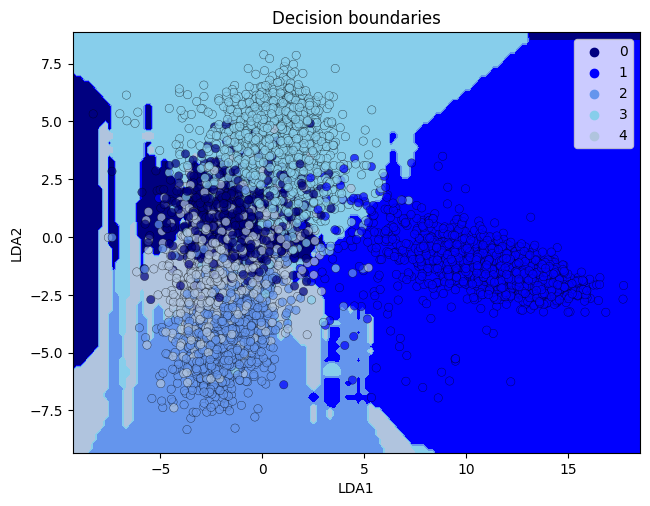

In [21]:
# Define subplots
fig, ax = plt.subplots()
plt.tight_layout();

cmap_light = ListedColormap(['navy','b','cornflowerblue','skyblue','lightsteelblue'])

# Plot decision boundery
ax.contourf(xx, yy, Z, 4, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(x='LDA1', y="LDA2", hue=y, data=X, palette=cmap_light, alpha=0.7, edgecolor="black", linewidth=0.3, ax=ax)
ax.set_title('Decision boundaries');